In [2]:
# Code based on SentDex Machine Learning Course
# Daniel Neamati 
# 3 July 2019


# Import Statements

# Data handling
import pandas as pd
import numpy as np

# Data source
import quandl

# Math
import math, datetime

# Machine Learning
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Choose the variable that you want to predict 
# (Run the next section to see an example data frame)

forecast_col = 'Adj. Close'

In [4]:
# Choose your stock here and run the rest of the notebook

df = quandl.get('WIKI/TSLA', authtoken='SvToyu-X_Rqvmdvab_LX')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0


In [5]:
# Choose only the columns of interest

df_Small = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df_Small.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0


In [6]:
# Add Additional Columns of relevant factors

# Percent Volatility (High - Low) percent
df_Small['HL_PCT'] = (df_Small['Adj. High'] - df_Small['Adj. Low']) \
                            / df_Small['Adj. Close'] * 100.0

# Percent Change
df_Small['PCT_change'] = (df_Small['Adj. Close'] - df_Small['Adj. Open']) \
                            / df_Small['Adj. Open'] * 100

# Now we make a new data frame of the most relevant columns
df_New = df_Small[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

# Now we want to deal with any missing data (e.g. NaN) by replacing it with outliers.
df_New.fillna(-9999, inplace = True)

df_New.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2010-06-29,23.89,31.226455,25.736842,18766300.0
2010-06-30,23.83,29.874948,-7.599845,17187100.0
2010-07-01,21.96,25.728597,-12.160000,8218800.0
2010-07-02,19.20,22.864583,-16.521739,5139800.0
2010-07-06,16.11,25.884544,-19.450000,6866900.0


In [7]:
# Now we want to make our label


timeScaleForecast = int(math.ceil(0.01 * len(df_New)))

df_New['label'] = df[forecast_col].shift(-timeScaleForecast)
df_New.head(40)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2010-06-29,23.89,31.226455,25.736842,18766300.0,20.720
2010-06-30,23.83,29.874948,-7.599845,17187100.0,20.350
2010-07-01,21.96,25.728597,-12.160000,8218800.0,19.940
2010-07-02,19.20,22.864583,-16.521739,5139800.0,20.920
2010-07-06,16.11,25.884544,-19.450000,6866900.0,21.950
2010-07-07,15.80,10.443038,-3.658537,6921700.0,21.260
2010-07-08,17.46,11.168385,8.178439,7711400.0,20.450
2010-07-09,17.40,7.758621,-1.023891,4050600.0,19.590
2010-07-12,17.05,6.275660,-5.013928,2202500.0,19.600


In [8]:
# Common Notation is X as features and y as labels

X = np.array(df_New.drop(['label'], 1)) # Keep all but 'label'
# To scale X before the classifier
# Would not be used with real time data
X = preprocessing.scale(X) 

# We want to separate the X values that have and don't have labels
X_WithLabel = X[:-timeScaleForecast]
X_NoLabel = X[-timeScaleForecast:]


df_New.dropna(inplace = True) # Remove the NaN or empty from dataframe
y = np.array(df_New['label']) # Only Keep 'label'

assert len(X_WithLabel) == len(y), '{} vs. {}'.format(len(X_WithLabel), len(y)) # Make sure each X has a corresponding y

# Now Split X and y
percentSplit = 0.2
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
                                    X_WithLabel, y, \
                                    test_size = percentSplit)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [9]:
# Now we make the Linear Regression classifier

stock_classifier = LinearRegression()
stock_classifier.fit(X_train, y_train)
accuracy = stock_classifier.score(X_test, y_test)

print(accuracy)

0.9631999138312363


In [10]:
# Not with a different classifier (namely, SVM)

stock_classifier_SVM = svm.SVR()
stock_classifier_SVM.fit(X_train, y_train)
accuracy_SVM = stock_classifier_SVM.score(X_test, y_test)

print(accuracy_SVM)

0.8761085072940804


In [11]:
# Now we do the prediction

forecast_set = stock_classifier.predict(X_NoLabel)

# Initialize the new predicted column
df_New['Forecast'] = np.nan

# We want the dates so that we can graph forecast by time
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day_secs = 86400
next_unix = last_unix + one_day_secs

empty_row = [np.nan for _ in range(len(df_New.columns) - 1)]

for forecast in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day_secs
    
    df_New.loc[next_date] = empty_row + [forecast]

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# Now we plot
df_New.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-04-11 17:00:00,NaN,NaN,NaN,NaN,NaN,315.623651
2018-04-12 17:00:00,NaN,NaN,NaN,NaN,NaN,307.817119
2018-04-13 17:00:00,NaN,NaN,NaN,NaN,NaN,301.870811
2018-04-14 17:00:00,NaN,NaN,NaN,NaN,NaN,304.839561
2018-04-15 17:00:00,NaN,NaN,NaN,NaN,NaN,282.489573


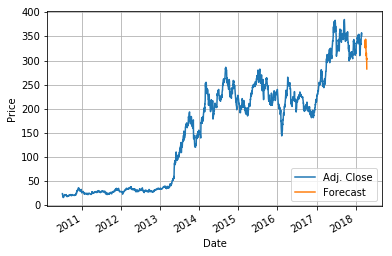

In [13]:
%matplotlib inline

df_New[forecast_col].plot()
df_New['Forecast'].plot()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = 4)

plt.show()